In [1]:
# import emcee
import matplotlib.pyplot as plt
import scipy.stats
from scipy import interpolate
from scipy import integrate
import numpy as np
#import corner
%matplotlib inline
np.random.seed(1)

area_f = integrate.simps(f(x), x)
area_e = integrate.simps(power_law(x), x)

p1 = f(x)/area_f
p2 = power_law(x)/area_e
c = np.convolve(p1, p2, mode='same')

plt.plot(x, f(x)/area_f, '.')
plt.plot(x, power_law(x)/area_e, '.')
plt.yscale('log')
plt.xscale('log')

In [2]:
from irf import power_law
import astropy.units as u

In [3]:
crab = power_law.CrabSpectrum()
e_min = 10*u.GeV
e_max = 200*u.TeV
t_obs = 1*u.h
area = 1*u.km**2

bins=np.logspace(-2, 2, 40, base=10)
centers = bins[0:-1]+np.diff(bins)/2

N = crab.expected_events(e_min, e_max, area, t_obs)

samples = crab.draw_energy_distribution(e_min=10*u.GeV, e_max=200*u.TeV, shape=int(N))

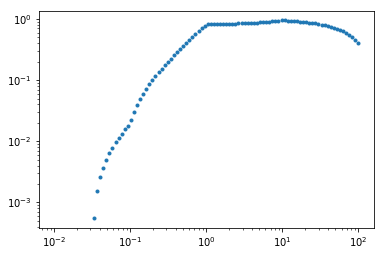

In [4]:
def acceptance_function():
    a = [0 , 0.0, 0.02,   0.2, 0.82, 0.95, 0.4]
    e = 10**np.array([-2, -1.5 , -1  ,  -0.5, 0   , 1   , 2])
    return interpolate.interp1d(e, a)

acceptance_prob = acceptance_function()

e = np.logspace(-2, 2, 100)
plt.plot(e, acceptance_prob(e), '.')
plt.xscale('log')
plt.yscale('log')

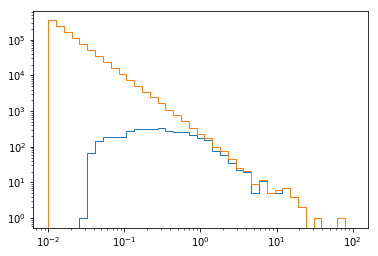

In [6]:

def apply_acceptance(samples, acceptance_prob):
    m  = np.random.uniform(0, 1, size=len(samples)) < acceptance_prob(samples)
    return samples[m]
    
triggered_samples = apply_acceptance(samples, acceptance_prob)

plt.hist(triggered_samples, bins=bins, histtype='step')
plt.hist(samples, bins=bins, histtype='step')
#plt.plot(centers, expected_events, '.')
plt.yscale('log')
plt.xscale('log')

Try and forward fold a model.

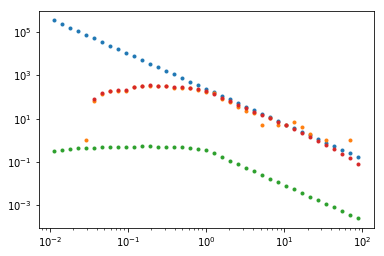

In [22]:
model = power_law.CrabSpectrum()

c_expected, edges  = model.expected_events_for_bins(e_min, e_max, area, t_obs, bins=bins*u.TeV)
c_measured, edges  = np.histogram(triggered_samples, bins=bins)

c_folded = c_expected * acceptance_prob(centers)

plt.plot(centers, c_expected, '.' )
plt.plot(centers, c_measured, '.')
plt.plot(centers, c_folded, '.')

plt.yscale('log')
plt.xscale('log')

In [49]:
def likelihood(A, index, data):
    
    if A < 0.9 or A > 1.1:
        return -np.inf
    if index < -3 or index > -2:
        return -np.inf 
    
    c_measured, edges  = np.histogram(data, bins=bins)
    
    model = power_law.Spectrum(index=index, normalization_constant=A*1/(u.GeV * u.km**2 * u.h))
    c_expected, edges  = model.expected_events_for_bins(e_min, e_max, area, t_obs, bins=bins*u.TeV)
    c_folded = c_expected * acceptance_prob(centers)
    
    g = (c_folded - c_measured)**2 / c_folded
    g[g==np.inf] = 0
    g  = np.nan_to_num(g)
    chi_square = np.sum(g)
    return -0.5 * chi_square
 


In [50]:
index = -2.62
A = (2.83e-14 / (u.GeV * u.cm**2 * u.s)).to(1/(u.GeV * u.km**2 * u.h))
likelihood(A.value, index, data=triggered_samples)

1.0188000000000001 1 / (GeV h km2)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


-22.862488683391852